# Assignment 6 
by [Jay Nakum](https://jaynakum.github.io) [20BCP304D]

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from evalml.preprocessing import split_data
from evalml.automl import AutoMLSearch

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
data = pd.read_csv('./datasets/diabetes.csv')
data.head()

In [ ]:
data.describe()

In [ ]:
data['Outcome'].value_counts()

In [5]:
x = data.drop('Outcome', axis=1)
y = data['Outcome']

In [6]:
# Normalising data
x = (x - x.mean()) / x.std()

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y)
xtrain.shape

### Pipelining for feature selection 

In [ ]:
pip = Pipeline([('constant', DropConstantFeatures(tol=0.9)), ('duplicate', DropDuplicateFeatures()), ('correlated', SmartCorrelatedSelection(threshold=0.9, estimator=SVC))])
new_xtrain = pip.fit_transform(xtrain)
new_xtrain.shape

In [ ]:
sm=SMOTE()
xtrain_new, ytrain_new = sm.fit_resample(xtrain, ytrain)
ytrain_new.value_counts(), ytest.value_counts()

### Running Models 

#### 1) SVC 

In [10]:
model1 = SVC()
model1.fit(xtrain_new, ytrain_new)

SVC()

In [11]:
pred1 = model1.predict(xtest)
print(accuracy_score(ytest, pred1))

0.6875


#### 2) Random Forest Classifier 

In [12]:
model2 =  RandomForestClassifier()
model2.fit(xtrain_new, ytrain_new)

RandomForestClassifier()

In [13]:
pred2 = model2.predict(xtest)
print(accuracy_score(ytest, pred2))

0.7083333333333334


### AutoML  Data Splitting

In [ ]:
xtrain, xtest, ytrain, ytest = split_data(x, y, problem_type='binary')
ytrain.value_counts(), xtrain.shape

In [ ]:
# SMOTE
sm=SMOTE()
xtrain_new, ytrain_new = sm.fit_resample(xtrain, ytrain)
ytrain_new.value_counts(), ytest.value_counts()

### AutoML Search 

In [ ]:
auto = AutoMLSearch(xtrain_new, ytrain_new, problem_type='binary')
auto.search()
print(auto.best_pipeline)

In [ ]:
auto.rankings

In [ ]:
auto.describe_pipeline(auto.rankings.iloc[0]["id"])

In [19]:
best = auto.best_pipeline
best.score(xtest, ytest, objectives=['auc', 'precision', 'recall', 'f1'])

OrderedDict([('AUC', 0.8555555555555555),
             ('Precision', 0.7407407407407407),
             ('Recall', 0.7407407407407407),
             ('F1', 0.7407407407407407)])

In [ ]:
best.graph()

### Creating and Running the model  

In [21]:
model = best
model.fit(xtrain, ytrain)

pipeline = BinaryClassificationPipeline(component_graph={'Label Encoder': ['Label Encoder', 'X', 'y'], 'Replace Nullable Types Transformer': ['Replace Nullable Types Transformer', 'X', 'Label Encoder.y'], 'Imputer': ['Imputer', 'Replace Nullable Types Transformer.x', 'Replace Nullable Types Transformer.y'], 'Random Forest Classifier': ['Random Forest Classifier', 'Imputer.x', 'Replace Nullable Types Transformer.y']}, parameters={'Label Encoder':{'positive_label': None}, 'Imputer':{'categorical_impute_strategy': 'most_frequent', 'numeric_impute_strategy': 'mean', 'boolean_impute_strategy': 'most_frequent', 'categorical_fill_value': None, 'numeric_fill_value': None, 'boolean_fill_value': None}, 'Random Forest Classifier':{'n_estimators': 100, 'max_depth': 6, 'n_jobs': -1}}, random_seed=0)

In [22]:
pred = model.predict(xtest)

### Results 

In [23]:
print('Accuracy Score:', accuracy_score(ytest, pred))

Accuracy Score: 0.8181818181818182


<AxesSubplot:>

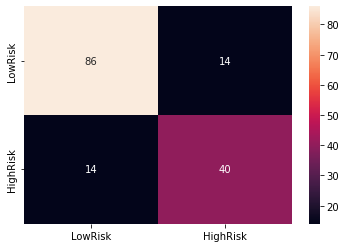

In [24]:
mat = confusion_matrix(ytest, pred)
sns.heatmap(mat, annot=True, fmt='d', xticklabels=['LowRisk', 'HighRisk'], yticklabels=['LowRisk', 'HighRisk'])

In [25]:
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       100
           1       0.74      0.74      0.74        54

    accuracy                           0.82       154
   macro avg       0.80      0.80      0.80       154
weighted avg       0.82      0.82      0.82       154

